### Goal: Try different Cross-Validation methods and see which is best.

How do we define best? We want the cross-validated error to mimic the expected risk as well as possible.

In [173]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

### Generate AR(1) or AR(2)

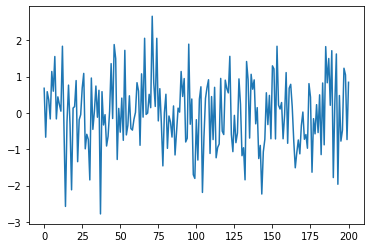

In [786]:
a = 0.12
b = 0.0
T = 201

def gen_ar1(a, T, s = 1):
    X = np.zeros(T)
    X[0] = np.random.normal(0, 1 / (1 - a ** 2 + 0.01))

    for t in range(1, T):
        X[t] = a * X[t - 1] + np.random.normal(0, s)
        
    return X

def gen_ar2(a, b, T):
    X = np.zeros(T)
    X[0] = np.random.normal(0, 1 / (1 - a ** 2 + 0.01))
    X[1] = X[0] * a + np.random.normal(0, 2)

    for t in range(2, T):
        X[t] = a * X[t - 1] + b * X[t - 2] + np.random.normal(0, 1)
        
    return X

def exp_cost_ar(a_true, a_est, s = 1):
    return s + (a_true - a_est) ** 2 * 1 / (1 - a_true ** 2)
    
X = gen_ar2(a, b, T)

plt.plot(X)

### LOOCV

In [794]:
def cv_1d(features, labels):
    """Leave One Out Cross-Validation for one dimensional features on labels"""
    
    T = np.shape(labels)[0]
    cv_scores = []
    
    # for each sample
    for i in range(T):
        # split data
        features_del, labels_del = np.delete(features, i), np.delete(labels, i)
        features_test, labels_test = features[i], labels[i]

        # train on del set
        coefs = 1 / (features_del @ features_del.T) * features_del @ labels_del

        # train on test set
        cv_scores.append((labels_test - features_test * coefs) ** 2)
    
    return np.mean(np.array(cv_scores)), np.cov(np.array(cv_scores))

m, c = cv_1d(X[:-1], X[1:])
print(f"LOOCV AR(1):\t{np.round(m, 2)} +/- {np.round(c, 2)}.")

LOOCV AR(1):	0.93 +/- 1.51.


### Block Cross Validation, NonDep CV

In [788]:
def bcv_1d(features, labels, h):
    """Leave One Out Cross-Validation for one dimensional features on labels"""
    
    T = np.shape(labels)[0]
    cv_scores = []
    
    # for each sample
    for i in range(T):
        
        # get range
        i_range = range(max(0, i - h), min(i + h + 1, T))

        # split data
        features_del, labels_del = np.delete(features, i_range), np.delete(labels, i_range)
        features_test, labels_test = features[i], labels[i]

        # train on del set
        coefs = 1 / (features_del @ features_del.T) * features_del @ labels_del

        # train on test set
        cv_scores.append((labels_test - features_test * coefs) ** 2)
    
    return np.mean(np.array(cv_scores)), np.cov(np.array(cv_scores))

h = 0
m, c = bcv_1d(X[:-1], X[1:], h)
print(f"{h}-block LOOCV AR(1):\t{np.round(m, 2)} +/- {np.round(c, 2)}.")

0-block LOOCV AR(1):	0.96 +/- 1.74.


### K-Fold cross validation, with and without shuffling

In [789]:
def kcv_1d(features, labels, k, shuffle = False):
    """Leave One Out Cross-Validation for one dimensional features on labels"""
    
    T = np.shape(labels)[0]
    cv_scores = []
    
    Fold = KFold(k, shuffle = shuffle)
    Fold.get_n_splits(features)
    for train_index, test_index in Fold.split(features):
       
        # split data
        features_del, labels_del = np.delete(features, test_index), np.delete(labels, test_index)
        features_test, labels_test = features[test_index], labels[test_index]
        
        # train on del set
        coefs = 1 / (features_del @ features_del.T) * features_del @ labels_del

        # train on test set
        cv_scores.append(1 / len(test_index) * np.linalg.norm(labels_test - features_test * coefs, 2) ** 2)
    
    #print(cv_scores)
    return np.mean(np.array(cv_scores)), np.cov(np.array(cv_scores))

k = 4
m, c = kcv_1d(X[:-1], X[1:], k, shuffle = False)
print(f"{k}-fold CV AR(1) No Shuffle:\t{np.round(m, 2)} +/- {np.round(c, 2)}.")

m, c = kcv_1d(X[:-1], X[1:], k, shuffle = True)
print(f"{k}-fold CV AR(1) W/ Shuffle:\t{np.round(m, 2)} +/- {np.round(c, 2)}.")

4-fold CV AR(1) No Shuffle:	0.95 +/- 0.0.
4-fold CV AR(1) W/ Shuffle:	0.96 +/- 0.03.


### k-Fold h-Block CV

In [790]:
def kbcv_1d(features, labels, k, h, shuffle = False):
    """Returns train test split"""

    cv_scores = []

    features_range = range(len(features))
    Fold = KFold(k, shuffle = shuffle)
    Fold.get_n_splits(features_range)
    
    for train_index, test_index in Fold.split(features_range):
        # get h_range
        h_ranges = [i * k for i in [-1, 1] for k in range(1, h + 1)]
        
        # get bounds
        bounds = set([i + j for j in h_ranges for i in test_index if i + j >= 0 and i + j < len(features)])
        
        # get complement of training set
        bounds.update(set(test_index))
        
        # get the training set
        train_index = np.delete(range(len(features)), list(bounds))
        
        if len(train_index)  == 0: continue

        # train on train set
        coefs = 1 / (features[train_index] @ features[train_index].T) * features[train_index] @ labels[train_index]

        # train on test set
        cv_scores.append(1 / len(test_index) * np.linalg.norm(labels[test_index] - features[test_index] * coefs, 2) ** 2)
        
    return np.mean(np.array(cv_scores)), np.cov(np.array(cv_scores))

k, h = 5, 2
T = 51
X = gen_ar1(a, T)
kbcv_1d(X[:-1], X[1:], 5, 1, shuffle = False)

(0.7944496375427533, array(0.02230747))

### Evaluate

In [791]:
# generate AR
a, T = 0.75, 51
X = gen_ar1(a, T)

# ground truth on data
print(f"True OLS Risk AR(1):\t\t\t{round(exp_cost_ar(a, 1 / (X[:-1] @ X[:-1].T) * X[:-1] @ X[1:], 1), 2)}.")

# do the four methods
m, c = cv_1d(X[:-1], X[1:])
print(f"LOOCV AR(1):\t\t\t\t{np.round(m, 2)} +/- {np.round(c, 2)}.")

h = 3
m, c = bcv_1d(X[:-1], X[1:], h)
print(f"{h}-block LOOCV AR(1):\t\t\t{np.round(m, 2)} +/- {np.round(c, 2)}.")

k = 10
m, c = kcv_1d(X[:-1], X[1:], k, shuffle = True)
print(f"{k}-fold CV AR(1) W/ Shuffle:\t\t{np.round(m, 2)} +/- {np.round(c, 2)}.")

m, c = kbcv_1d(X[:-1], X[1:], k, h, shuffle = True)
print(f"{k}-fold {h}-block CV AR(1) W/ Shuffle:\t{np.round(m, 2)} +/- {np.round(c, 2)}.")

True OLS Risk AR(1):			1.08.
LOOCV AR(1):				0.93 +/- 1.51.
3-block LOOCV AR(1):			0.93 +/- 1.46.
10-fold CV AR(1) W/ Shuffle:		0.93 +/- 0.32.
10-fold 3-block CV AR(1) W/ Shuffle:	0.93 +/- 0.26.


### Evaluate often

In [840]:
iterations = 5000
a, T = 0.4, 51

h, k, shuffle = 3, 5, True
exp_cost = []
loocv = []
loocv_c = []
hblockloocv = []
kfoldcv = []
kfoldhblockcv = []
ols = []
true_risk = []

print(f"Generate AR(1) with a = {round(a, 2)} for T = {T}. Iterate {iterations} times.")
for i in range(iterations):
    X = gen_ar1(a, T)

    # do the four methods
    m, c = cv_1d(X[:-1], X[1:])
    loocv.append(m)
    loocv_c.append(c)
    hblockloocv.append(bcv_1d(X[:-1], X[1:], h)[0])
#     kfoldcv.append(kcv_1d(X[:-1], X[1:], k, shuffle = shuffle)[0])
#     kfoldhblockcv.append(kbcv_1d(X[:-1], X[1:], k, h, shuffle = shuffle)[0])
    
    # true risk of OLS
    exp_cost.append(exp_cost_ar(a, 1 / (X[:-1] @ X[:-1].T) * X[:-1] @ X[1:], 1))
    
    # empirical risk minimizer
    a_ols = 1 / (X[:-1] @ X[:-1].T) * X[:-1] @ X[1:]
    ols.append(1 / (T - 1) * np.linalg.norm(X[1:] - a_ols * X[:-1], 2) ** 2)
    true_risk.append(1 / (T - 1) * np.linalg.norm(X[1:] - a * X[:-1], 2) ** 2)

rnd = 3
print(f"Expected Risk:\t\t{round(np.mean(np.array(exp_cost)), rnd)} +/- {np.round(np.cov(np.array(exp_cost)), rnd)}.\n")

print(f"LOOCV Risk:\t\t{round(np.mean(np.array(loocv)), rnd)} +/- {np.round(np.cov(np.array(loocv)), rnd)}.")
print(f"LOOCV Risk Variance:\t{round(np.mean(np.array(loocv_c)), rnd)} +/- {np.round(np.cov(np.array(loocv_c)), rnd)}.")
print(f"{h}-Block LOOCV Risk:\t{round(np.mean(np.array(hblockloocv)), rnd)} +/- {np.round(np.cov(np.array(hblockloocv)), rnd)}.")
# print(f"{k}-Fold CV Risk:\t\t{round(np.mean(np.array(kfoldcv)), rnd)} +/- {np.round(np.cov(np.array(kfoldcv)), rnd)}.")
# print(f"{k}-Fold {h}-Block CV Risk:\t{round(np.mean(np.array(kfoldhblockcv)), rnd)} +/- {np.round(np.cov(np.array(kfoldhblockcv)), rnd)}.")
print(f"True Risk:\t\t{round(np.mean(np.array(true_risk)), rnd)} +/- {np.round(np.cov(np.array(true_risk)), rnd)}.")
print(f"\nEmpirical Risk:\t\t{round(np.mean(np.array(ols)), rnd)} +/- {np.round(np.cov(np.array(ols)), rnd)}.")

Expected Risk:		1.02 +/- 0.001.

LOOCV Risk:		1.022 +/- 0.043.
LOOCV Risk Variance:	2.103 +/- 1.271.
3-Block LOOCV Risk:	1.025 +/- 0.044.
True Risk:		1.001 +/- 0.04.

Empirical Risk:		0.982 +/- 0.039.


### Leave Future Out CV

In [651]:
def lfocv_1d(features, labels, start  = 5, skip = 0, test_size = False):
    """Leave One Out Cross-Validation for one dimensional features on labels"""
    
    T = np.shape(labels)[0]
    cv_scores = []
    
    # for each sample
    for i in range(start, T - skip):
        
        # split data
        features_del, labels_del = np.delete(features, range(i, T)), np.delete(labels, range(i, T))
        features_test, labels_test = features[range(i + skip, T)], labels[range(i + skip, T)]
        
        if test_size: features_test, labels_test = np.array(features_test[0]).reshape(1, 1), np.array(labels_test[0]).reshape(1, 1)
        
        # train on del set
        coefs = 1 / (features_del @ features_del.T) * features_del @ labels_del

        # train on test set
        cv_scores.append(1 / len(labels_test) * np.linalg.norm(labels_test - features_test * coefs, 2) ** 2)
    
    return np.mean(np.array(cv_scores)), np.cov(np.array(cv_scores))

X = gen_ar1(a, T)
start, skip = 5, 0
m, c = lfocv_1d(X[:-1], X[1:], start = start, skip = skip, test_size = False)
print(f"LOOCV AR(1):\t{np.round(m, 2)} +/- {np.round(c, 2)}.")

LOOCV AR(1):	1.99 +/- 1.9.


### Investigate start moment

In [595]:
iters = 100
lfocv_means = [[] for h in range(5, T - 2)]
lfocv_covs = [[] for h in range(5, T - 2)] 

exp_cost = []

for i in range(iters):
    X = gen_ar1(a, T)
    exp_cost.append(exp_cost_ar(a, 1 / (X[:-1] @ X[:-1].T) * X[:-1] @ X[1:], 1))
    for start in range(5, T - 2):
        m, c = lfocv_1d(X[:-1], X[1:], start)
        lfocv_means[start - 5].append(m)
        lfocv_covs[start - 5].append(c)

print(f"Expected Risk:\t\t{round(np.mean(np.array(exp_cost)), rnd)} +/- {np.round(np.cov(np.array(exp_cost)), 3)}.\n")
print(np.round(np.array(np.mean(lfocv_means, axis = 1)), 2))
print(np.round(np.array(np.mean(lfocv_covs, axis = 1)), 2))

Expected Risk:		1.09 +/- 0.161.

[1.04 1.03 1.04 1.03 1.   0.99 0.97 0.98 0.99 1.01 1.01 1.   1.02 0.95]
[2.21 1.9  1.96 1.95 1.85 1.8  1.78 1.82 1.84 1.93 1.73 1.84 1.63 1.39]


### Investigate block size $h$

In [842]:
a, T, iters = 0.5, 51, 100
BCV_means = [[] for h in range(0, T // 2 - 1)]
BCV_covs = [[] for h in range(0, T // 2 - 1)] 

for i in range(iters):
    X = gen_ar1(a, T)
    for h in range(0, T // 2 - 1):
        m, c = bcv_1d(X[:-1], X[1:], h)
        BCV_means[h].append(m)
        BCV_covs[h].append(c)
        
print(np.round(np.array(np.mean(BCV_means, axis = 1)), 2))
print(np.round(np.array(np.mean(BCV_covs, axis = 1)), 2))

[1.02 1.02 1.02 1.02 1.02 1.03 1.03 1.03 1.03 1.03 1.03 1.03 1.04 1.04
 1.04 1.04 1.04 1.05 1.05 1.06 1.07 1.08 1.1  1.14]
[2.02 2.04 2.05 2.06 2.06 2.07 2.07 2.08 2.08 2.09 2.1  2.11 2.12 2.13
 2.12 2.13 2.14 2.16 2.16 2.19 2.26 2.37 2.47 3.28]


Larger block size $h$ seems bad, could be because of the data AR(1).

### Investigate number of folds $k$

In [861]:
a, T, iters = 0.5, 101, 1000
k_range = range(2, T - 1, 10)
KCV_means = [[] for k in k_range]
KCV_covs = [[] for k in k_range] 

for i in range(iters):
    X = gen_ar1(a, T)
    for j, k in enumerate(k_range):
        m, c = kcv_1d(X[:-1], X[1:], k)
        KCV_means[j].append(m)
        KCV_covs[j].append(c)

exp_cost = exp_cost_ar(a, a, 1)
print(np.round(np.array(np.mean(KCV_means, axis = 1) - exp_cost), 2))
print(np.round(np.array(np.mean(KCV_covs, axis = 1)), 2))

[0.02 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
[0.04 0.26 0.47 0.67 0.9  1.12 1.43 1.66 1.83 1.96]


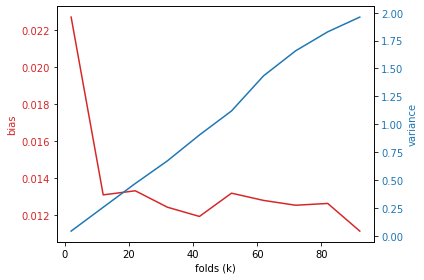

In [863]:
# Create some mock data
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('folds (k)')
ax1.set_ylabel('bias', color=color)
ax1.plot(k_range, np.array(np.mean(KCV_means, axis = 1) - exp_cost), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('variance', color=color)  # we already handled the x-label with ax1
ax2.plot(k_range, np.mean(KCV_covs, axis = 1), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

As the number of folds increases, the train samples become larger and the test samples become smaller. We see that the bias decreases; the KCV mean goes closer to the true value. Nevertheless, the variance of the estimator increases to $2s^4$.

After five or ten folds, it already seems okay.

### Evaluate LOOCV

In [746]:
iterations = 100
a, T = 0.5, 26

a_list = []
exp_cost = []
loocv = []
loocv_c = []
ols = []

for i in range(iterations):
    X = gen_ar1(a, T, 2)

    # do the four methods
    m, c = cv_1d(X[:-1], X[1:])
    loocv.append(m)
    loocv_c.append(c)
    
    # true risk of OLS
    a_est = 1 / (X[:-1] @ X[:-1].T) * X[:-1] @ X[1:]
    exp_cost.append(exp_cost_ar(a, a_est, 4))
    a_list.append(a_est)
    
    # empirical risk minimizer
    a_ols = 1 / (X[:-1] @ X[:-1].T) * X[:-1] @ X[1:]
    ols.append(1 / (T - 1) * np.linalg.norm(X[1:] - a_ols * X[:-1], 2) ** 2)

rnd = 3
print(f"Expected Risk:\t\t{round(np.mean(np.array(exp_cost)), rnd)} +/- {np.round(np.cov(np.array(exp_cost)), rnd)}.")
print(f"LOOCV Risk:\t\t{round(np.mean(np.array(loocv)), rnd)} +/- {np.round(np.cov(np.array(loocv)), rnd)}.")
print(f"LOOCV C Risk:\t\t{round(np.mean(np.array(loocv_c)), rnd)} +/- {np.round(np.cov(np.array(loocv_c)), rnd)}.")
print(f"Empirical Risk:\t\t{round(np.mean(np.array(ols)), rnd)} +/- {np.round(np.cov(np.array(ols)), rnd)}.")
print(f"\nValue for a:\t\t{round(np.mean(np.array(a_list)), rnd)} +/- {np.round(np.cov(np.array(a_list)), rnd)}.")

Expected Risk:		4.042 +/- 0.006.
LOOCV Risk:		4.233 +/- 1.361.
LOOCV C Risk:		37.142 +/- 580.154.
Empirical Risk:		3.903 +/- 1.176.

Value for a:		0.464 +/- 0.03.


In [778]:
X = gen_ar1(a, T, 2)
residuals = np.append(X[0], X[1:] - a * X[:-1])
print(1 / (X[:-1] @ X[:-1].T) * X[:-1] @ X[1:])
print(a + (residuals[1:] * X[:-1]).sum() / (X[:-1] ** 2).sum())
print((residuals[1:] * X[:-1]).mean())

0.6724579096996494
0.672457909699649
1.1427108132089476
